<details>
   <summary>Metadata</summary>
    title: "E-TRAINEE Tutorial - Sentinel-2 snow cover time series classification in Python"<br>
    description: "This is a tutorial within the third theme of Module 1 of the E-TRAINEE course."<br>
    lastUpdate: 2023-07-20<br>
    authors: Andreas Mayr<br>
</details>

# Sentinel-2 snow cover time series classification in Python

This Notebook shows how to implement a simple snow classification workflow on a Sentinel-2 (S-2) satellite image time series.

For a small area-of-interest (AOI) in the Alps (Obergurgl, Austria), an **S-2 Normalized Difference Snow Index (NDSI) time series** is downloaded from the Google Earth Engine (GEE) and **classified per-scene** into snow-covered and snow-free areas, using the widely used NDSI threshold of 0.4. The results of this simple **rule-based classification** are analysed and visualized regarding the **duration of snow cover** (months) per pixel and percentage of **snow-covered area** within the AOI per month.

For Google Earth Engine (GEE) and `xarray` based raster time series processing we use the [geemap](https://geemap.org/), [wxee](https://wxee.readthedocs.io/en/latest/index.html) and [eemont](https://eemont.readthedocs.io/) packages, which are contained in the requirements file provided for the course. Please see the instructions on the [software page](https://3dgeo-heidelberg.github.io/etrainee/software/software_python.html) for setting up a Conda environment based on this file.

Import packages, then authenticate and initialize Google Earth Engine.

In [1]:
import ee, eemont, geemap, wxee

In [4]:
try:
        wxee.Initialize()
except Exception as e:          # If initialize does not work, you probably have to authenticate first
        ee.Authenticate()
        wxee.Initialize()

## Construct an area-of-interest (AOI)

We want a area around Obergurgl (Tyrol, Austria) as our area-of-interest (AOI). Using `eemont`, we pass a query for this place via the `geopy` package to a geocoding service. We just provide a string representing a place that is geocoded. A Bounding Box (`ee.Geometry.BBox`) for a geocoded place can be constructed from such a query using the `ee.Geometry.BBoxFromQuery` constructor (extended through `eemont`). Depending on the geocoding service used (e.g., ArcGIS, Baidu, Google Maps, IGN France, Nominatim, etc.), the resulting Bounding Boxes will differ. In this example, the method is convenient because we don't have to enter any coordinates for our AOI or import a file.

In [5]:
AOI = ee.Geometry.BBoxFromQuery("Obergurgl, Austria", user_agent = "RS_course")

The `user_agent` argument must be specified: This is a string describing the name of the app that is using a geocoding service.

The `geemap` package can directly display the `ee.Geometry.BBox` object with our AOI in an interactive map.

In [6]:
Map = geemap.Map()
Map.addLayer(AOI,{'color':'blue'}, 'Nominatim')  # Use Nominatim, the Open Street Map geocoding service
Map.centerObject(AOI, 10)
Map

Map(center=[46.87037509744985, 11.02749840000902], controls=(WidgetControl(options=['position', 'transparent_b…

Retrieve an image collection from GEE, preprocess it and calculate the NDSI.

In [7]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterDate("2022-01-01","2022-06-30") \
    .filterBounds(AOI) \
    .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 30) \
    .preprocess() \
    .spectralIndices("NDSI") \
    .select("NDSI")

We have filtered by a date range and by bounds, i.e. queried imagery for the year 2022 and for our AOI.
The eemont ``preprocess()`` method automatically masks clouds and shadows and scales and offsets the image or image collection. The eemont ``spectralIndices()`` method can calculate any index from the [Awesome Spectral Indices](https://awesome-ee-spectral-indices.readthedocs.io/en/latest/) library. For snow classification we will only use the NDSI, no original bands.

## Aggregate and download time series

Create a wxee `TimeSeries` object from the image collection to to add more functionality, such as temporal aggregations.

In [8]:
S2_ts = S2.wx.to_time_series()

First, get some info about our time series.

In [9]:
S2_ts.describe()

COPERNICUS/S2_SR
	Images: 68
	Start date: 2022-01-01 10:27:43 UTC
	End date: 2022-06-27 10:18:12 UTC
	Mean interval: 2.64 days


And plot the timeline to see how the (low-cloudiness) observations are distributed over the observation period.

In [10]:
S2_ts.wx.to_time_series().timeline()

Perform a temporal aggregation (calculate monthly medians) of our time series in the GEE.

In [11]:
S2_monthly_ts= S2_ts.aggregate_time(frequency="month", reducer=ee.Reducer.median())

Now use wxee to get the result of the time series aggregation to an xarray `Dataset` (i.e. download the aggregated rasters). You could also download multiple images as GeoTIFFs. Wxee, however, is not designed to download larger areas and high resolution - in such cases consider downloading to a Google Drive using `ee` or to a local drive using `geemap`. *In our case 12 months with 20 m resolution throw a GEE memory error ("User memory exceeded"). Therefore, we split the request and download simply into two parts with 6 months each.*

Either define a path where a NetCDF file will be written to, or load the `Dataset` into memory.
You can set the `scale` parameter to control the resolution. See the [wxee documentation](https://wxee.readthedocs.io/en/latest/generated/wxee.collection.ImageCollection.to_xarray.html) for more options.

The requests and downloads may take some minutes.

In [12]:
S2_ds_1 = S2_monthly_ts.wx.to_xarray(region = AOI, crs='EPSG:25832', scale=20)

Requesting data:   0%|          | 0/6 [00:00<?, ?it/s]

We repeat the data query and the download for the second part of the year.

In [13]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterDate("2022-07-01","2022-12-31") \
    .filterBounds(AOI) \
    .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 30) \
    .preprocess() \
    .spectralIndices("NDSI") \
    .select("NDSI")                                                                     # Query S2 NDSI from GEE
S2_ts = S2.wx.to_time_series()                                                          # Build wxee time series object
S2_monthly_ts= S2_ts.aggregate_time(frequency="month", reducer=ee.Reducer.median())     # Reduce NDSI to monthly median
S2_ds_2 = S2_monthly_ts.wx.to_xarray(region = AOI, crs='EPSG:25832', scale=20)          # Download monthly NDSI

Requesting data:   0%|          | 0/6 [00:00<?, ?it/s]

Concatenate the two xarray Datasets (six months of monthly NDSI each) along the time dimension and check the final Dataset we obtained.

In [14]:
import xarray as xr
S2_ds = xr.concat([S2_ds_1, S2_ds_2], dim='time')
S2_ds

<xarray.Dataset>
Dimensions:      (time: 12, x: 159, y: 227)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-01T10:27:57 ... 2022-12-07T10:...
  * x            (x) float64 6.529e+05 6.53e+05 6.53e+05 ... 6.561e+05 6.561e+05
  * y            (y) float64 5.195e+06 5.195e+06 ... 5.191e+06 5.19e+06
    spatial_ref  int32 0
Data variables:
    NDSI         (time, y, x) float64 0.8335 0.8201 0.7924 ... 0.7509 0.6929
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

Note that we have only downloaded the monthly medians of the NDSI, no other bands.

## Show NDSI maps

Display the monthly NDSI maps using `xarray`'s built-in plotting functions:

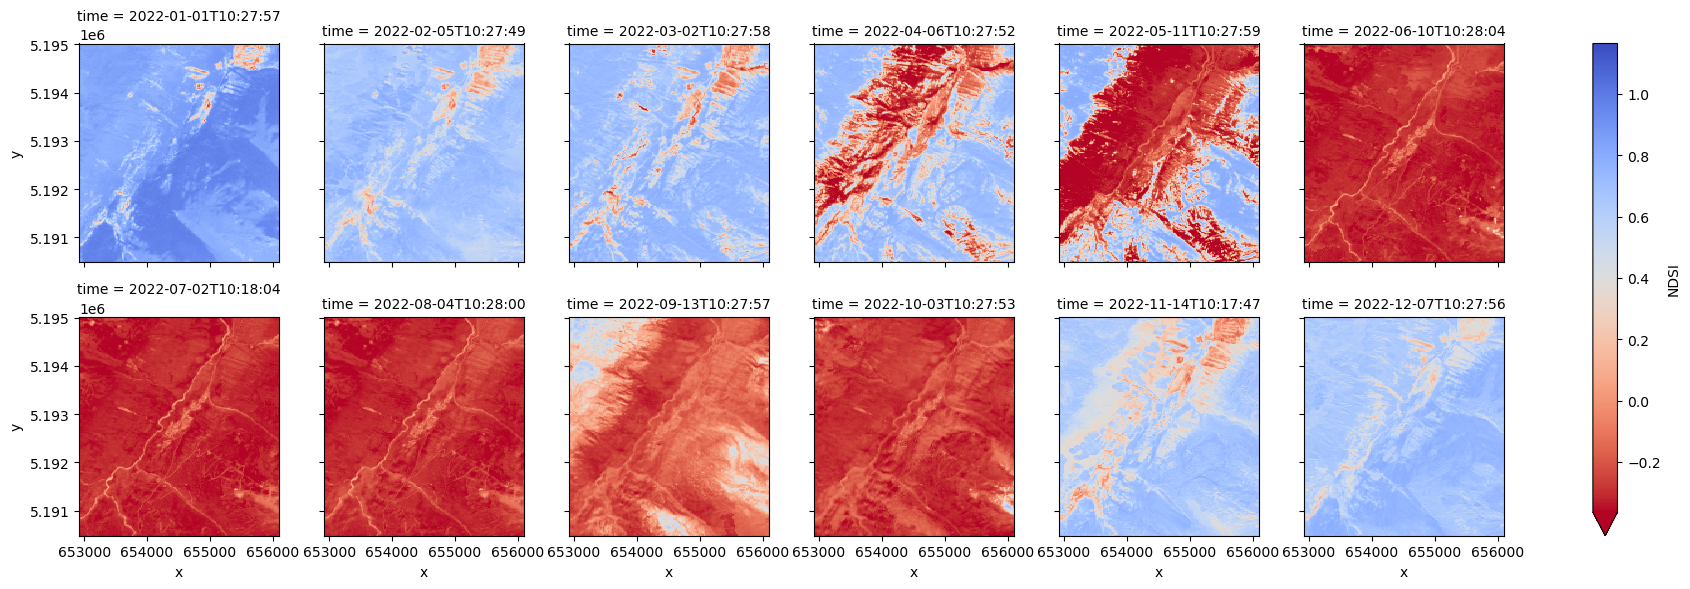

In [15]:
S2_ds.NDSI.plot(col="time", col_wrap=6, cmap='coolwarm_r', center=0.4, aspect=1, robust=True)

## Snow classification for each month

Now we map binary snow cover simply by thresholding the NDSI with the widely used threshold 0.4 (which we also took to center the colormap in the plot above). This results in a time series of monthly snow/no-snow maps (encoded as 1/0).

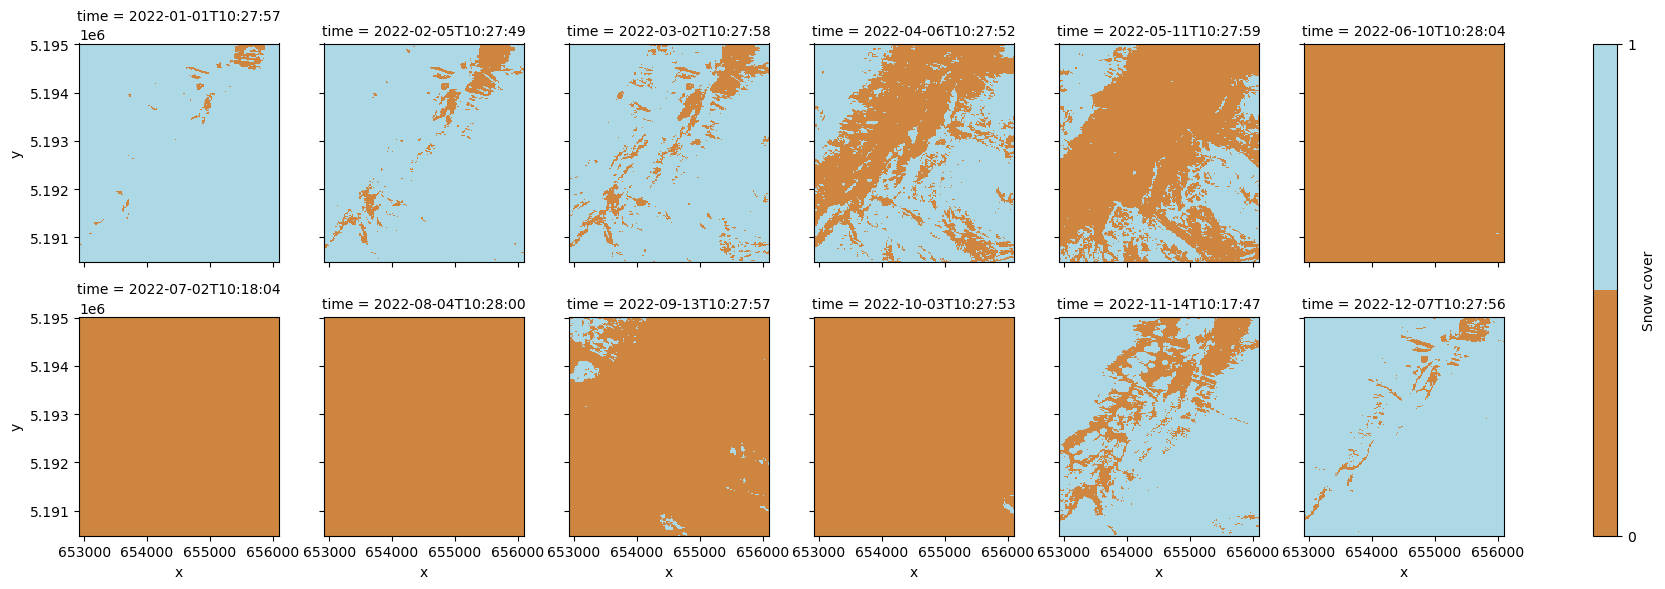

In [24]:
import xarray as xr
from matplotlib.colors import ListedColormap
snow = xr.where(S2_ds.NDSI>0.4, 1, 0)
snow.attrs = S2_ds.attrs        # Copy the attributes of the S2 Dataset (CRS, spatial res., ...)
cmap = ListedColormap(['peru', 'lightblue'])
snow.plot(col='time', col_wrap=6, cbar_kwargs={'label': 'Snow cover', 'ticks': [0, 1]}, cmap=cmap)

Let's take this time series of snow/no-snow maps to quantify the percentage of our area-of-interest that is snow covered for each month. 

In [17]:
import numpy as np
snow_percentage = np.nanmean(snow.values, axis=(1,2))*100

... and plot this.

Text(0, 0.5, 'Snow covered area [%]')

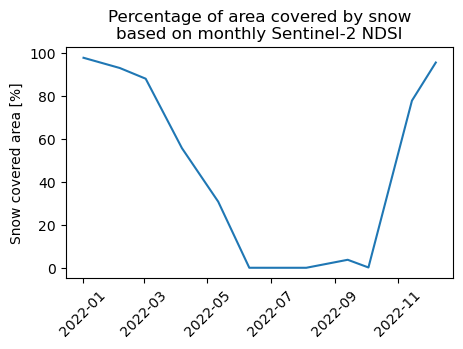

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(snow.time, snow_percentage)
plt.title("Percentage of area covered by snow\nbased on monthly Sentinel-2 NDSI")
plt.xticks(rotation=45)
plt.ylabel("Snow covered area [%]")

## Snow cover duration per pixel

Finally calculate how many months every pixel is snow covered.

Text(0.5, 1.0, 'Snow cover duration 2022')

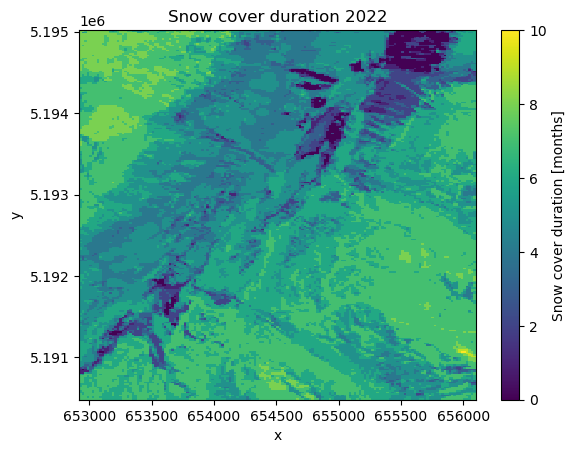

In [19]:
snow.sum(dim='time').plot(cbar_kwargs={'label': 'Snow cover duration [months]'})
plt.title('Snow cover duration 2022')